# pyGAM Quickstart: TAVG PCA Coefficients

Fit smooth additive models to the TAVG PCA coefficients prepared in `GAMsForWeather/tavg_gams_prep.ipynb`. We scale predictors, optionally subsample, train `LinearGAM` models for the first three PCs, and inspect partial dependence plus model fit.


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

DATA_PATH = Path("/home/yfreund/weather_data/per_row_coefficients.parquet").resolve()

In [2]:
# Data path defined above; proceed to load and filter coefficients.


In [3]:
predictor_cols = ["latitude", "dist_to_coast", "elevation"]
component_cols = ["PC1", "PC2", "PC3", "PC4", "PC5"]

tavg_df = pd.read_parquet(DATA_PATH)
if "ELEMENT" in tavg_df.columns:
    tavg_df = tavg_df[tavg_df["ELEMENT"] == "TAVG"].reset_index(drop=True)
elif "element" in tavg_df.columns:
    tavg_df = tavg_df[tavg_df["element"] == "TAVG"].reset_index(drop=True)



In [4]:
available_components = [col for col in component_cols if col in tavg_df.columns]

if not available_components:
    raise ValueError("No PCA component columns were found in the coefficient dataset")

available_components = available_components[:3]

tavg_df = tavg_df.dropna(subset=predictor_cols + available_components).copy()
tavg_df[predictor_cols + available_components] = tavg_df[predictor_cols + available_components].astype(float)
tavg_df = tavg_df[predictor_cols + available_components]
tavg_df.head()


,latitude,dist_to_coast,elevation,PC1,PC2,PC3
0,41.117,221.167,1509.0,1181.187658,-1628.747705,-91.175263
1,41.117,221.167,1509.0,1233.941454,-1588.863613,-64.689131
2,41.117,221.167,1509.0,1115.967543,-1432.061767,-142.679642
3,41.117,221.167,1509.0,1122.428958,-1504.756770,-29.399955
4,41.117,221.167,1509.0,1168.601544,-1475.255536,-57.378708


In [5]:
X = tavg_df[predictor_cols].to_numpy()


In [6]:
sample_size = 100_000
rng = np.random.default_rng(0)

if len(X) > sample_size:
    idx = rng.choice(len(X), size=sample_size, replace=False)
    X_sample = X[idx]
    df_sample = tavg_df.iloc[idx].reset_index(drop=True)
else:
    X_sample = X
    df_sample = tavg_df.reset_index(drop=True)

X_sample = np.asarray(X_sample, dtype=float)
X_sample.shape, df_sample.shape


((100000, 3), (100000, 6))

In [ ]:
  import scipy.sparse as sps   # a patch to deal with sparsee matrices
  if not hasattr(sps.spmatrix, "A"):
      sps.spmatrix.A = property(lambda self: self.toarray())

In [9]:
models = {}
for component in available_components:
    y = df_sample[component].to_numpy(dtype=float)
    gam = LinearGAM(s(0) + s(1) + s(2)).gridsearch(X_sample, y, progress=False)
    models[component] = gam
    pseudo_r2 = gam.statistics_.get("pseudo_r2", float("nan"))
    if isinstance(pseudo_r2, dict):
        pseudo_r2 = next(iter(pseudo_r2.values()))
    print(f"{component}: pseudo-R^2={float(pseudo_r2):.3f}")


PC1: pseudo-R^2=0.724
PC2: pseudo-R^2=0.441
PC3: pseudo-R^2=0.079


ValueError: too many values to unpack (expected 1)

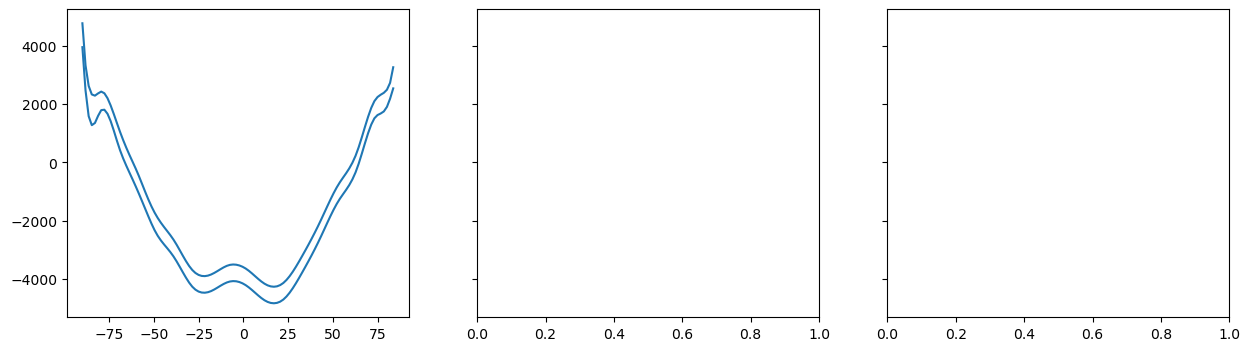

In [ ]:
for component in available_components:
    gam = models[component]
    fig, axes = plt.subplots(1, len(predictor_cols), figsize=(15, 4), sharey=True)
    quantiles = {col: np.percentile(df_sample[col], [10, 50, 90]) for col in predictor_cols}

    for term, ax in enumerate(axes):
        XX = gam.generate_X_grid(term=term)
        pd_result = gam.partial_dependence(term=term, X=XX, width=0.95)
        if len(pd_result) == 3:
            _, pdep, confi = pd_result
            is_ci_tuple = True
        else:
            _, pdep = pd_result
            is_ci_tuple = False

        ax.plot(XX[:, term], pdep, color="tab:blue", label="Partial dependence")
        if is_ci_tuple:
            ax.fill_between(XX[:, term], confi[0], confi[1], color="tab:blue", alpha=0.2, label="95% CI")

        percentile_labels = ["10th percentile", "Median", "90th percentile"]
        percentile_styles = [
            dict(color="green", linestyle="dashed", linewidth=2),
            dict(color="red", linestyle="solid", linewidth=2),
            dict(color="purple", linestyle="dashed", linewidth=2),
        ]

        for q_idx, q_val in enumerate([0, 1, 2]):
            baseline = np.tile([quantiles[col][q_val] for col in predictor_cols], (XX.shape[0], 1))
            baseline[:, term] = XX[:, term]
            pdep_quant = gam.predict(baseline)
            ax.plot(
                XX[:, term],
                pdep_quant,
                label=percentile_labels[q_idx],
                **percentile_styles[q_idx],
            )

        ax.set_title(f"{component}: {predictor_cols[term]}")
        ax.set_xlabel(predictor_cols[term])
        ax.grid(True)
        ax.axhline(0, color="k", linestyle=":", linewidth=1)

        if term == 0:
            ax.legend(loc="best")

    axes[0].set_ylabel("Partial dependence")
    fig.suptitle(f"Partial Dependence for {component}", y=1.04)
    fig.tight_layout()
    plt.show()


In [11]:
r2_results = {}
for comp in available_components:
    y_true = df_sample[comp].to_numpy(dtype=float)
    preds = models[comp].predict(X_sample)
    ss_res = np.sum((y_true - preds) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    r2_results[comp] = r2
    print(f"{comp}: R^2 = {r2:.3f}")

r2_df = pd.DataFrame.from_dict(r2_results, orient="index", columns=["R2"])
r2_df.loc["Average"] = r2_df["R2"].mean()
r2_df


PC1: R^2 = 0.724
PC2: R^2 = 0.441
PC3: R^2 = 0.079


,R2
PC1,0.724398
PC2,0.441438
PC3,0.079039
Average,0.414958
